In [1]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers

import numpy as np

import keras
import keras.layers as layers
import keras.backend as K
import keras.utils

import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime
import time
import struct

from typing import Tuple, Optional

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import Dark2_5 as palette
import itertools
def convert_btr_2_npy(poi: Optional[Tuple[int, int]], import_file_path: str, traces_path_exp: Optional[str] = None) -> np.ndarray:
    """Binary traces(.btr) 파일을 numpy.ndarray 의 직렬화된 파일로 저장하는 함수

    :param poi: 일부만 추출할 경우 인자 전달. 전체 파형을 추출할 경우 None 전달
    :param import_file_path: .btr 파일의 위치 (경로 + 파일명)
    :param traces_path_exp:  변환된 numpy.ndarray 객체 파일이 저장될 위치 (경로 + 파일명). 확장자는 .npy로 한다.
    :return: numpy array로 변환된 파형 데이터
    """
    print('Binary Traces file. (.btr)')
    print('-' * 50)
    _fp = open(import_file_path, 'rb')

    _trace_num = struct.unpack('i', _fp.read(4))[0]  # num of traces
    _trace_sample = struct.unpack('i', _fp.read(4))[0]  # samples

    _trunc_range, _trunc_len = __poi_converter(poi, _trace_sample)

    _traces = np.empty(shape=(_trace_num, _trunc_len))

    for _i in range(_trace_num):
        __trace_index = struct.unpack('i', _fp.read(4))[0]
        _traces[_i] = struct.unpack(str(_trace_sample) + 'f', _fp.read(_trace_sample * 4))[_trunc_range[0]: _trunc_range[1] + 1]
        print(f'\r* Trace-{__trace_index + 1}', end='', flush=True)

    _fp.close()
    print()
    print('-' * 50)

    if traces_path_exp is not None:
        np.save(traces_path_exp, _traces)
        print(f'Traces - {traces_path_exp} saved.')

    return _traces
    pass

def convert_hex_data_2_npy(import_file_path: str, export_file_path: Optional[str] = None) -> np.ndarray:
    """16진수 문자열로 구성된 평문/암호문 파일을 읽어 numpy.ndarray 의 직렬화된 파일로 저장하는 함수

    :param import_file_path: 평문/암호문의 16진수 문자열이 나열된 텍스트 파일 위치 (경로 + 파일명)
    :param export_file_path: numpy.ndarray로 변환되어 저장될 파일의 위치 (경로 + 파일명). 확장자는 .npy로 한다.
    :return: numpy array로 변환된 데이터
    """
    _fp = open(import_file_path, 'r')
    _data = _fp.readlines()
    for i in range(len(_data)):
        _data[i] = _data[i].replace(" ", "").replace("\n", "")

    _data = np.array(_data)

    if export_file_path is not None:
        np.save(export_file_path, _data)

    return _data
    pass

def __poi_converter(poi: Tuple[int, int], _samples) -> Tuple[Tuple[int, int], int]:
    """POI의 범위를 검사하고 반환해주는 함수

    :param poi: (시작, 끝)으로 이루어진 poi 범위
    :param _samples: 파형의 실제 샘플수
    :return: (poi, poi_len)
    """
    if poi is None: _trunc_range = (0, _samples - 1)  # 0 ~ 25002-1
    else: _trunc_range = (poi[0], poi[1])  # 1 ~ 25002

    _trunc_len = _trunc_range[1] - _trunc_range[0] + 1

    if _trunc_range[0] < 0 or _trunc_range[1] > _samples - 1 or _trunc_len <= 0:
        raise RuntimeError("\nPOI error. All: poi=None, else: (a, b). a>=0, b<=SAMPLES")

    return _trunc_range, _trunc_len
    pass

In [2]:
# 구글 드라이브 마운트 - 드라이브에 저장된 파일에 접근하기 위해 필요함
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = "/content/drive/MyDrive/2112/"


# convert .btr to .npy
#np.load("/content/drive/MyDrive/2112/profile1.npy")
profile_trace  = np.load("/content/drive/MyDrive/2112/profile1.npy")#convert_btr_2_npy((17500,23500), file_path + 'ML-AVR-SEED.btr', '/content/drive/MyDrive/2112/profile1.npy')
profile_plain  = convert_hex_data_2_npy(file_path + 'ML-AVR-SEED-plain.txt',None)
profile_key    = convert_hex_data_2_npy(file_path + 'ML-AVR-SEED-key.txt', None)

In [4]:
SBox1 = [
    169,  133,  214,   211,  84,  29,  172,  37,
    93,  67,  24,   30,  81,  252,  202,  99,
    40,  68,  32,   157,  224,  226,  200,  23,
    165,  143,  3,   123,  187,  19,  210,  238,
    112,  140,  63,   168,  50,  221,  246,  116,
    236,  149, 11,  87,  92,  91,  189,  1,
  36,  28,  115,  152,  16,  204,  242,  217,
    44, 231, 114, 131, 155, 209, 134, 201,
    96, 80, 163, 235, 13, 182, 158, 79,
    183, 90, 198, 120, 166, 18, 175, 213,
    97, 195, 180, 65, 82, 125, 141, 8,
    31, 153, 0, 25, 4, 83, 247, 225,
    253, 118, 47, 39, 176, 139, 14, 171,
    162, 110, 147, 77, 105, 124, 9, 10,
    191, 239,243, 197, 135, 20, 254, 100,
    222, 46,  75, 26, 6, 33, 107, 102,
    2, 245,  146, 138,  12, 179, 126, 208,
    122, 71,  150, 229, 38, 128, 173, 223,
    161, 48,  55, 174, 54, 21, 34, 56,
    244, 167,  69, 76, 129, 233, 132, 151,
    53, 203, 206, 60, 113, 17, 199, 137,
    117, 251,  218, 248, 148, 89, 130, 196,
    255, 73,  57, 103, 192, 207, 215, 184,
    15, 142, 66, 35, 145,108, 219, 164,
    52, 241, 72, 194, 111, 61, 45, 64,
    190, 62, 188, 193, 170, 186, 78, 85,
   59, 220, 104, 127, 156, 216, 74, 86,
    119, 160, 237, 70, 181, 43, 101, 250,
    227, 185,177, 159, 94, 249, 230, 178,
    49, 234, 109, 95, 228, 240, 205, 136,
    22, 58, 88, 212, 98, 41, 7, 51,
    232, 27, 5, 121, 144, 106, 42, 154
]
SBox2 = [
    56, 232, 45, 166, 207, 222, 179, 184,
    175, 96, 85, 199, 68, 111, 107, 91,
    195, 98, 51, 181, 41, 160, 226, 167,
    211, 145, 17, 6, 28, 188, 54, 75,
    239, 136, 108, 168, 23, 196, 22, 244,
    194, 69, 225, 214, 63, 61, 142, 152,
    40, 78, 246, 62, 165, 249, 13, 223,
    216, 43, 102, 122, 39, 47, 241, 114,
    66, 212, 65, 192, 115, 103, 172, 139,
    247, 173, 128, 31, 202, 44, 170, 52,
    210, 11, 238, 233, 93, 148, 24, 248,
    87, 174, 8, 197, 19, 205, 134, 185,
    255, 125, 193, 49, 245, 138, 106, 177,
    209, 32, 215, 2, 34, 4, 104, 113,
    7, 219, 157, 153, 97, 190, 230, 89,
    221, 81, 144, 220, 154, 163, 171, 208,
    129,  15, 71, 26, 227, 236, 141, 191,
    150, 123, 92, 162, 161, 99, 35, 77,
    200, 158, 156, 58, 12, 46, 186, 110,
    159, 90, 242, 146, 243, 73, 120, 204,
    21, 251, 112, 117, 127, 53, 16, 3,
    100, 109, 198, 116, 213, 180, 234, 9,
    118, 25, 254, 64, 18, 224, 189, 5,
    250, 1, 240, 42, 94, 169, 86, 67,
    133, 20, 137, 155, 176, 229, 72, 121,
    151, 252, 30, 130, 33, 140, 27, 95,
    119, 84, 178, 29, 37, 79, 0, 70,
    237, 88, 82, 235, 126, 218, 201, 253,
    48, 149, 101, 60, 182, 228, 187, 124,
    14, 80, 57, 38, 50, 132, 105, 147,
    55, 231, 36, 164, 203, 83, 10, 135,
    217, 76, 131, 143, 206, 59, 74, 183

]
m0 = 0xfc
m1 = 0xf3
m2 = 0xcf
m3 = 0x3f

def list2hex(A):

 a = 0 
 for i in range(0,4):

      a ^= int(A[i])<<8*(3-i)
 
 return a



def G(text):
    text[0] = SBox2[text[0]]
    text[1] = SBox1[text[1]]
    text[2] = SBox2[text[2]]
    text[3] = SBox1[text[3]]
    

    output =  [(text[3]&m3) ^(text[2]&m0) ^(text[1]&m1)^(text[0]&m2), 
               (text[3]&m2) ^(text[2]&m3) ^(text[1]&m0)^(text[0]&m1),
               (text[3]&m1) ^(text[2]&m2) ^(text[1]&m3)^(text[0]&m0),
               (text[3]&m0) ^(text[2]&m1) ^(text[1]&m2)^(text[0]&m3)]
    return output

def round_1_key(Key):
    A = Key[0:4]
    B = Key[4:8]
    C = Key[8:12]
    D = Key[12:16]
    KC0 = [0x9e,0x37,0x79,0xb9]
    mod = 0x1 << 32


    k = ((list2hex(A)+list2hex(C))%mod -list2hex(KC0))%mod
    t = ((list2hex(B)-list2hex(D))%mod +list2hex(KC0))%mod
   

    KL_sp = np.array([(k>>(8*(3-i)))&0xFF for i in range(0,4)])
    KR_sp = np.array([(t>>(8*(3-i)))&0xFF for i in range(0,4)])
    
    
    KL = G(KL_sp)
    KR = G(KR_sp)


    
    return KL, KR
def G_sbox(text):
    text[0] = SBox2[text[0]]
    text[1] = SBox1[text[1]]
    text[2] = SBox2[text[2]]
    text[3] = SBox1[text[3]]


In [5]:

profile_traces_normal = np.array(profile_trace[:])


# 정규화 수행
for i in range(profile_traces_normal.shape[0]):
    profile_traces_normal[i] -= profile_traces_normal[i].mean()
    MIN = min(profile_traces_normal[i])
    MAX = max(profile_traces_normal[i])
    profile_traces_normal[i] = ((profile_traces_normal[i] - MIN)/(MAX - MIN) - 0.5) * 2 #정규화를 진행

In [6]:

plain_list =  np.array([[int(profile_plain[k][i:i+2], 16)for i in range(0,len(profile_plain[0]),2)]for k in range(0, 5000)])
keys_list =  np.array([[int(profile_key[k][i:i+2], 16) for i in range(0,len(profile_key[0]),2)] for k in range(0, 5000)])
print(plain_list[0])
plain_list_L = np.array([ [(plain_list[j][i]) for i in range(0,8)]for j in range(0,5000)]) #이거 쉽게 plain_list_L = plain_list[:, :8] 하면될껄
plain_list_R = np.array([[(plain_list[j][8+i]) for i in range(0,8)]for j in range(0,5000)]) #plain_list_L = plain_list[:, 8:]
    
print(plain_list_R[0])
plain_list_C = np.array([[(plain_list_R[j][i]) for i in range(0,4)]for j in range(0,5000)]) #애두
plain_list_D = np.array([[(plain_list_R[j][4+i]) for i in range(0,4)]for j in range(0,5000)])
print('c = ', plain_list_C)

Sbox_input = np.array([[]])
KeyL_list= np.array([])
KeyR_list= np.array([])




#Sbox_input = np.zeros(5000,4)
for i in range(0,5000):
  KeyL, KeyR = round_1_key(keys_list[i])
  #print(KeyL)
  KeyL_list = np.append(KeyL_list,  KeyL, axis=0)
  KeyR_list = np.append(KeyR_list,  KeyR, axis=0)
KeyL_list = np.reshape(KeyL_list,(5000,4))
KeyR_list = np.reshape(KeyR_list,(5000,4))
KeyL_list = KeyL_list.astype('uint32')
KeyR_list = KeyR_list.astype('uint32')

Sbox_input = plain_list_C^KeyL_list^plain_list_D^KeyR_list


for i in range(0,5000):
  for j in range(0,4):
    if j%2 == 0:
      Sbox_input[i][j] =  SBox2[Sbox_input[i][j]]
    else:
      Sbox_input[i][j] =  SBox1[Sbox_input[i][j]]

mid_value = Sbox_input
mid_value

print('s_box =', Sbox_input[0])

[  0  17  34  51  68  85 102 119 136 153 170 187 204 221 238 255]
[136 153 170 187 204 221 238 255]
c =  [[136 153 170 187]
 [ 96 122  43  78]
 [ 73 219 161  39]
 ...
 [217 142 252 248]
 [227  67 213 123]
 [  2 179 106 176]]
s_box = [188 158 153 204]


In [7]:

# 학습에 쓰일 파형의 개수 설정
num_traces = profile_trace.shape[0]
num_training = int(num_traces * 0.9)

# SBox 결과
#mid_value

# 데이터 셔플링
rand_index = np.arange(0, num_traces)
np.random.shuffle(rand_index)

# 학습에서 사용할 입력(x_train)과 레이블(y_train)을 설정
x_train = profile_traces_normal[rand_index[:num_training]]
y_train = mid_value[rand_index[:num_training]]


# 검증에서 사용할 입력(x_valid)과 레이블(y_valid)을 설정
x_valid = profile_traces_normal[rand_index[num_training:]]
y_valid = mid_value[rand_index[num_training:]]

# 학습 데이터와 검증 데이터의 shape을 출력
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

(4500, 6001)
(4500, 4)
(500, 6001)
(500, 4)


In [8]:
target_byte = 0

# 원핫 인코딩 수행
category = keras.layers.CategoryEncoding(256, output_mode = 'one_hot')
y_train_onehot1 = category(y_train[:,target_byte])
y_valid_onehot1 = category(y_valid[:,target_byte])

print(y_train_onehot1.shape)
print(y_valid_onehot1.shape)

#========================================
target_byte = 1

# 원핫 인코딩 수행
category = keras.layers.CategoryEncoding(256, output_mode = 'one_hot')
y_train_onehot2 = category(y_train[:,target_byte])
y_valid_onehot2 = category(y_valid[:,target_byte])

print(y_train_onehot2.shape)
print(y_valid_onehot2.shape)
#===========================================
target_byte = 2

# 원핫 인코딩 수행
category = keras.layers.CategoryEncoding(256, output_mode = 'one_hot')
y_train_onehot3 = category(y_train[:,target_byte])
y_valid_onehot3 = category(y_valid[:,target_byte])

print(y_train_onehot3.shape)
print(y_valid_onehot3.shape)
#======================================================
target_byte = 3

# 원핫 인코딩 수행
category = keras.layers.CategoryEncoding(256, output_mode = 'one_hot')
y_train_onehot4 = category(y_train[:,target_byte])
y_valid_onehot4 = category(y_valid[:,target_byte])

print(y_train_onehot4.shape)
print(y_valid_onehot4.shape)

(4500, 256)
(500, 256)
(4500, 256)
(500, 256)
(4500, 256)
(500, 256)
(4500, 256)
(500, 256)


In [9]:
def build_MLP(Points_len = 6001, Hidden_node = [400, 200], Output_node = 256, Activations = "relu", Dropout = True, BatchNo = False):

    # 입력층
    inp = keras.layers.Input(shape = (Points_len, ), name = "input") 

    # 입력층 배치 정규화
    Hidden_layer = keras.layers.BatchNormalization()(inp)

    for node in Hidden_node:
        # 은닉층 추가
        Hidden_layer = keras.layers.Dense(node, activation = Activations)(Hidden_layer)
        if Dropout: # 드롭아웃 수행
            Hidden_layer = keras.layers.Dropout(0.5)(Hidden_layer)
        if BatchNo: # 배치 정규화 수행
            Hidden_layer = keras.layers.BatchNormalization()(Hidden_layer)
    
    # 활성화 함수를 softmax로 설정 (각 class일 확률을 반환)
    out = keras.layers.Dense(Output_node, activation = 'softmax', name = 'output')(Hidden_layer)

    # 입력층과 출력층을 받아서 객체화
    m = keras.Model(inp, out)

    # 손실함수를 categorical_crossentropy, 성능 지표를 정확도로 설정하여 모델을 구성
    m.compile(optimizer = keras.optimizers.adam_v2.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    # 모델 shape과 파라미터 수를 출력
    m.summary(80)

    return m

In [10]:
SCA_MLP1 = build_MLP(6001, [1024, 512], 256, "relu", True, True)
SCA_MLP2 = build_MLP(6001, [1024, 512], 256, "relu", True, True)
SCA_MLP3 = build_MLP(6001, [1024, 512], 256, "relu", True, True)
SCA_MLP4 = build_MLP(6001, [1024, 512], 256, "relu", True, True)


Model: "model"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 input (InputLayer)                 [(None, 6001)]                  0           
                                                                                
 batch_normalization (BatchNormaliz  (None, 6001)                   24004       
 ation)                                                                         
                                                                                
 dense (Dense)                      (None, 1024)                    6146048     
                                                                                
 dropout (Dropout)                  (None, 1024)                    0           
                                                                                
 batch_normalization_1 (BatchNormal  (None, 1024)                   4096        
 ization)    

In [11]:
def train(model, Init, epochs, x_train, y_train, x_valid, y_valid, batch_size, verbose, file_name):

    # epoch 20 동안 validation accuracy의 향상이 없으면 학습 중지
    earlystop = keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 20, verbose = 1)

    # validation accuracy가 향상된 결과의 모델 파라미터만 저장
    checkpoint = keras.callbacks.ModelCheckpoint(filepath = './MLSCA', monitor = 'val_accuracy', verbose = verbose, save_best_only = True, mode = 'max')
  
    # 학습 시작 시간 측정
    print("Training started: ", datetime.datetime.now())
    start = time.time()
    
    # 가중치 초기화 
    model.set_weights(Init)

    # 신경망 학습 수행
    model.fit(x = x_train, y = y_train, validation_data = (x_valid, y_valid), initial_epoch = 0, epochs = epochs, batch_size = batch_size, callbacks=[checkpoint], verbose = verbose)

    # 학습 종료 시간 측정 및 소요 시간 계산
    elapsed = time.time() - start
    print("Training ended: ", datetime.datetime.now())
    print("Elapsed", elapsed)
    
    val_loss_load = model.history.history['val_loss']
    val_acc_load = model.history.history['val_accuracy']
    loss_load = model.history.history['loss']
    acc_load = model.history.history['accuracy']

    # 학습 결과 그래프 출력
    fig = plt.figure(figsize = (16, 6))
    ax = plt.subplot(1, 2, 1)
    ax.plot(loss_load)
    ax.plot(val_loss_load)
    ax.legend(['loss','val_loss'])
    ax = plt.subplot(1, 2, 2)
    ax.plot(acc_load)
    ax.plot(val_acc_load)
    ax.legend(['accuracy','val_accuracy'])
    plt.savefig(file_name + 'val_loss_and_acc.png')
    plt.show()
    
    # 학습 결과, 손실값과 정확도를 파일로 저장
    np.savetxt(file_name+"val_loss.txt", val_loss_load)
    np.savetxt(file_name+"val_acc.txt", val_acc_load)

Training started:  2021-11-21 07:10:29.703600
Epoch 1/50
89/90 [============================>.] - ETA: 0s - loss: 6.1018 - accuracy: 0.0052
Epoch 00001: val_accuracy improved from -inf to 0.01000, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 8s 45ms/step - loss: 6.1004 - accuracy: 0.0051 - val_loss: 5.5846 - val_accuracy: 0.0100
Epoch 2/50
89/90 [============================>.] - ETA: 0s - loss: 5.8974 - accuracy: 0.0070
Epoch 00002: val_accuracy did not improve from 0.01000
90/90 [==============================] - 1s 13ms/step - loss: 5.8993 - accuracy: 0.0069 - val_loss: 5.6055 - val_accuracy: 0.0020
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 5.6576 - accuracy: 0.0109
Epoch 00003: val_accuracy did not improve from 0.01000
90/90 [==============================] - 1s 13ms/step - loss: 5.6576 - accuracy: 0.0109 - val_loss: 5.4779 - val_accuracy: 0.0020
Epoch 4/50
90/90 [=======================

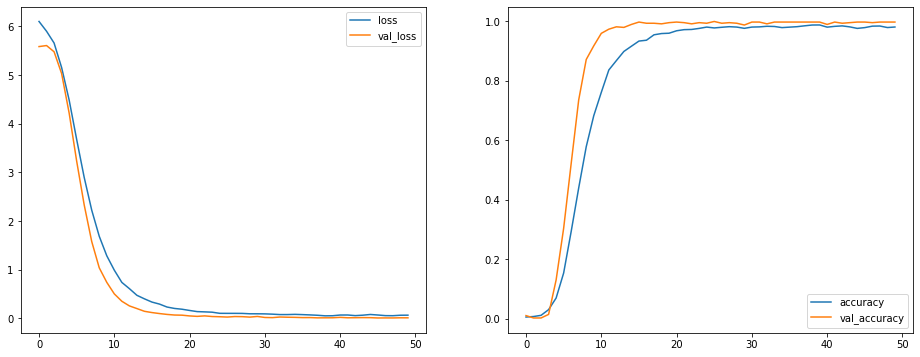

Training started:  2021-11-21 07:12:05.572258
Epoch 1/50
90/90 [==============================] - ETA: 0s - loss: 6.1070 - accuracy: 0.0056
Epoch 00001: val_accuracy improved from -inf to 0.00200, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 5s 41ms/step - loss: 6.1070 - accuracy: 0.0056 - val_loss: 5.6137 - val_accuracy: 0.0020
Epoch 2/50
88/90 [============================>.] - ETA: 0s - loss: 5.9129 - accuracy: 0.0057
Epoch 00002: val_accuracy improved from 0.00200 to 0.01200, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 4s 40ms/step - loss: 5.9103 - accuracy: 0.0060 - val_loss: 5.6098 - val_accuracy: 0.0120
Epoch 3/50
89/90 [============================>.] - ETA: 0s - loss: 5.7163 - accuracy: 0.0101
Epoch 00003: val_accuracy did not improve from 0.01200
90/90 [==============================] - 1s 12ms/step - loss: 5.7159 - accuracy: 0.0100 - va

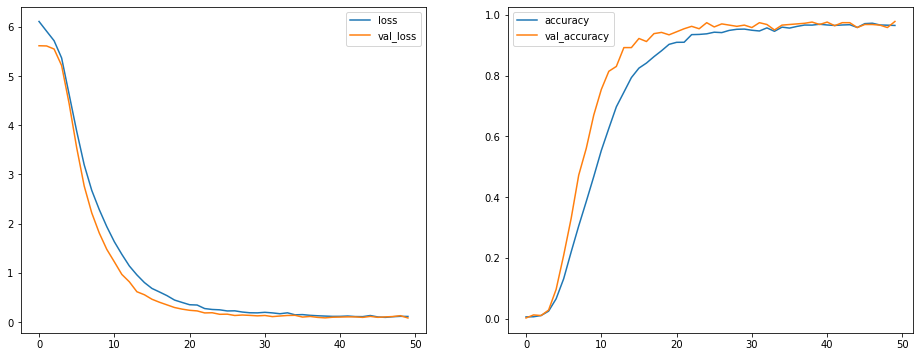

Training started:  2021-11-21 07:14:29.317440
Epoch 1/50
90/90 [==============================] - ETA: 0s - loss: 6.0694 - accuracy: 0.0024
Epoch 00001: val_accuracy improved from -inf to 0.00200, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 5s 42ms/step - loss: 6.0694 - accuracy: 0.0024 - val_loss: 5.5741 - val_accuracy: 0.0020
Epoch 2/50
89/90 [============================>.] - ETA: 0s - loss: 5.8456 - accuracy: 0.0067
Epoch 00002: val_accuracy improved from 0.00200 to 0.01000, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 3s 39ms/step - loss: 5.8453 - accuracy: 0.0067 - val_loss: 5.5518 - val_accuracy: 0.0100
Epoch 3/50
89/90 [============================>.] - ETA: 0s - loss: 5.5029 - accuracy: 0.0189
Epoch 00003: val_accuracy improved from 0.01000 to 0.02800, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [======

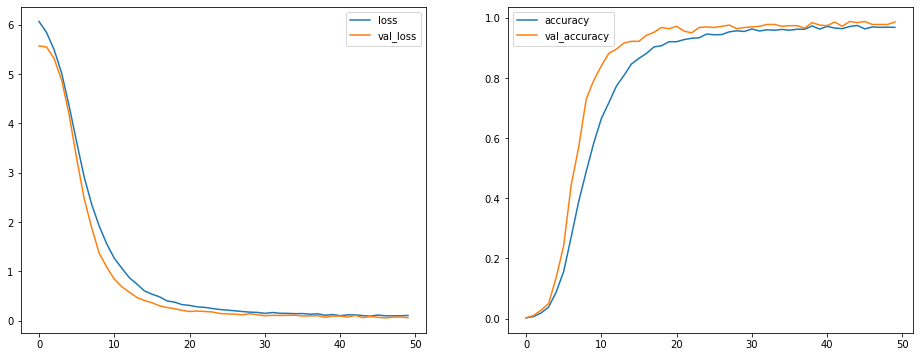

Training started:  2021-11-21 07:16:30.430869
Epoch 1/50
90/90 [==============================] - ETA: 0s - loss: 6.0949 - accuracy: 0.0053
Epoch 00001: val_accuracy improved from -inf to 0.00400, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 5s 46ms/step - loss: 6.0949 - accuracy: 0.0053 - val_loss: 5.5987 - val_accuracy: 0.0040
Epoch 2/50
87/90 [============================>.] - ETA: 0s - loss: 5.8693 - accuracy: 0.0076
Epoch 00002: val_accuracy improved from 0.00400 to 0.00800, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 4s 41ms/step - loss: 5.8709 - accuracy: 0.0080 - val_loss: 5.5996 - val_accuracy: 0.0080
Epoch 3/50
87/90 [============================>.] - ETA: 0s - loss: 5.6307 - accuracy: 0.0138
Epoch 00003: val_accuracy improved from 0.00800 to 0.01000, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [======

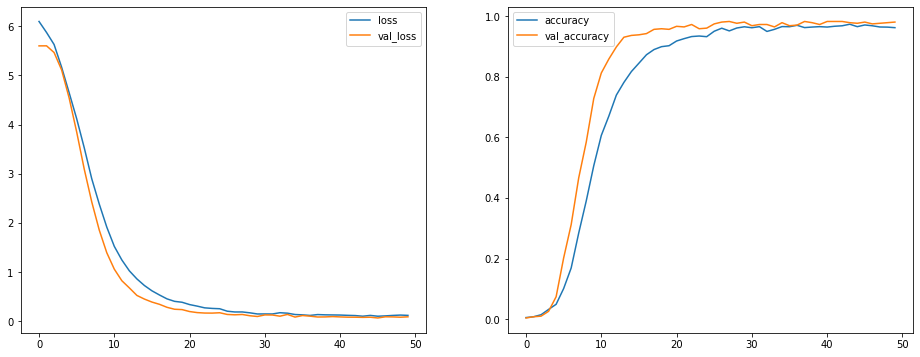

In [12]:
init_weights1 = SCA_MLP1.get_weights()

train(SCA_MLP1,init_weights1 , 50 ,x_train , y_train_onehot1, x_valid, y_valid_onehot1,50, 1,'seed_attack_model1')
#=============================================================================================================================
init_weights2 = SCA_MLP2.get_weights()
train(SCA_MLP2,init_weights2 , 50 ,x_train , y_train_onehot2, x_valid, y_valid_onehot2,50, 1,'seed_attack_model2')
#=============================================================================================================================
init_weights3 = SCA_MLP3.get_weights()

train(SCA_MLP3,init_weights3 , 50 ,x_train , y_train_onehot3, x_valid, y_valid_onehot3,50, 1,'seed_attack_model3')
#=============================================================================================================================
init_weights4 = SCA_MLP4.get_weights()

train(SCA_MLP4,init_weights4 , 50 ,x_train , y_train_onehot4, x_valid, y_valid_onehot4,50, 1,'seed_attack_model4')

In [13]:
file_path = "/content/drive/MyDrive/2111/"


# convert .btr to .npy
attack_trace  = np.load('/content/drive/MyDrive/2111/attack2.npy')#convert_btr_2_npy((30000,36000), file_path + 'AVR-SEED.btr', '/content/drive/MyDrive/2111/attack2.npy')
attack_plain  = convert_hex_data_2_npy(file_path + 'AVR-SEED-plain.txt',None)
attack_key    = convert_hex_data_2_npy(file_path + 'AVR-SEED-key.txt', None)

In [14]:
inv_SBox1= [90, 47, 128, 26, 92, 250, 124, 246, 87, 110, 111, 42, 132, 68, 102, 184, 52, 165, 77, 29, 117, 149, 240, 23, 10, 91, 123, 249, 49, 5, 11, 88, 18, 125, 150, 187, 48, 7, 140, 99, 16, 245, 254, 221, 56, 198, 121, 98, 145, 232, 36, 247, 192, 160, 148, 146, 151, 178, 241, 208, 163, 197, 201, 34, 199, 83, 186, 9, 17, 154, 219, 137, 194, 177, 214, 122, 155, 107, 206, 71, 65, 12, 84, 93, 4, 207, 215, 43, 242, 173, 73, 45, 44, 8, 228, 235, 64, 80, 244, 15, 119, 222, 127, 179, 210, 108, 253, 126, 189, 234, 105, 196, 32, 164, 58, 50, 39, 168, 97, 216, 75, 251, 136, 27, 109, 85, 134, 211, 141, 156, 174, 59, 158, 1, 62, 116, 239, 167, 131, 101, 33, 86, 185, 25, 252, 188, 130, 106, 172, 41, 138, 159, 51, 89, 255, 60, 212, 19, 70, 227, 217, 144, 104, 66, 191, 24, 76, 153, 35, 0, 204, 103, 6, 142, 147, 78, 100, 226, 231, 133, 82, 220, 69, 72, 183, 225, 205, 28, 202, 46, 200, 112, 180, 203, 195, 81, 175, 115, 74, 166, 22, 63, 14, 161, 53, 238, 162, 181, 135, 61, 30, 3, 243, 79, 2, 182, 213, 55, 170, 190, 209, 37, 120, 143, 20, 95, 21, 224, 236, 139, 230, 57, 248, 157, 233, 67, 40, 218, 31, 113, 237, 193, 54, 114, 152, 129, 38, 94, 171, 229, 223, 169, 13, 96, 118, 176]
inv_SBox2= [214, 185, 107, 167, 109, 183, 27, 112, 90, 175, 246, 81, 148, 54, 232, 129, 166, 26, 180, 92, 193, 160, 38, 36, 86, 177, 131, 206, 28, 211, 202, 75, 105, 204, 108, 142, 242, 212, 235, 60, 48, 20, 187, 57, 77, 2, 149, 61, 224, 99, 236, 18, 79, 165, 30, 240, 0, 234, 147, 253, 227, 45, 51, 44, 179, 66, 64, 191, 12, 41, 215, 130, 198, 157, 254, 31, 249, 143, 49, 213, 233, 121, 218, 245, 209, 10, 190, 88, 217, 119, 153, 15, 138, 84, 188, 207, 9, 116, 17, 141, 168, 226, 58, 69, 110, 238, 102, 14, 34, 169, 151, 13, 162, 111, 63, 68, 171, 163, 176, 208, 158, 199, 59, 137, 231, 97, 220, 164, 74, 128, 203, 250, 237, 192, 94, 247, 33, 194, 101, 71, 205, 134, 46, 251, 122, 25, 155, 239, 85, 225, 136, 200, 47, 115, 124, 195, 146, 114, 145, 152, 21, 140, 139, 125, 243, 52, 3, 23, 35, 189, 78, 126, 70, 73, 89, 8, 196, 103, 210, 6, 173, 19, 228, 255, 7, 95, 150, 230, 29, 182, 117, 135, 67, 98, 40, 16, 37, 91, 170, 11, 144, 222, 76, 244, 159, 93, 252, 4, 127, 104, 80, 24, 65, 172, 43, 106, 56, 248, 221, 113, 123, 120, 5, 55, 181, 42, 22, 132, 229, 197, 118, 241, 1, 83, 174, 219, 133, 216, 82, 32, 186, 62, 154, 156, 39, 100, 50, 72, 87, 53, 184, 161, 201, 223, 178, 96]

In [15]:
attack_plain_list =  np.array([[int(attack_plain[k][i:i+2], 16)for i in range(0,len(attack_plain[0]),2)]for k in range(0, 2000)])
attack_keys_list =  np.array([[int(attack_key[k][i:i+2], 16) for i in range(0,len(attack_key[0]),2)] for k in range(0, 1)])
#print(plain_list[0])
attack_plain_list_L = np.array([ [(attack_plain_list[j][i]) for i in range(0,8)]for j in range(0,2000)])
attack_plain_list_R = np.array([[(attack_plain_list[j][8+i]) for i in range(0,8)]for j in range(0,2000)])
    
#print(plain_list_R[0])
attack_plain_list_C = np.array([[(attack_plain_list_R[j][i]) for i in range(0,4)]for j in range(0,2000)])
attack_plain_list_D = np.array([[(attack_plain_list_R[j][4+i]) for i in range(0,4)]for j in range(0,2000)])
plain = attack_plain_list_C^attack_plain_list_D

KL,KR = round_1_key(attack_keys_list[0])
KL = np.array(KL)
KR = np.array(KR)

print(KL,KR)
KL^KR

[227  82 243  32] [ 78  55 195 203]


array([173, 101,  48, 235])

In [16]:
attack_traces_normal = np.array(attack_trace[:])

# 정규화 수행
for i in range(attack_trace.shape[0]):
    attack_traces_normal[i] -= attack_traces_normal[i].mean()
    MIN = min(attack_traces_normal[i])
    MAX = max(attack_traces_normal[i])
    attack_traces_normal[i] = ((attack_traces_normal[i] - MIN)/(MAX - MIN) - 0.5) * 2 #정규화를 진행


In [17]:

def predict_MLP_s(model1,model2,model3,model4, trace_test, pts_test):

    # 신경망의 출력 값(sbox 출력 값) 획득
    predict_sbox1 = model1.predict(trace_test)

    # one-hot encoding 결과 값 중 최대 값의 인덱스 추출
   
    sbox_out_val1 = np.argmax(predict_sbox1,axis=1)
    
    sbox_in_val1 = np.array(inv_SBox2)[sbox_out_val1.astype(int)]

    guess_key1 = pts_test[:,0]^sbox_in_val1
   
    # 1바이트의 키 후보 별 계산된 추측 키 카운팅
    unique, counts = np.unique(guess_key1, return_counts = True)
    key_count = np.zeros(256)
    key_count[unique] = counts

    # 가장 많이 카운팅 된 추측 키 계산
    pred_key1 = np.argmax(key_count)
    
    print('right key1: ', (pred_key1))

    plt.figure(figsize = (16, 6))
    plt.plot(key_count)
    plt.xlabel('key candidates')
    plt.show()
#=================================================================================================
    predict_sbox2 = model2.predict(trace_test)

    # one-hot encoding 결과 값 중 최대 값의 인덱스 추출
   
    sbox_out_val2 = np.argmax(predict_sbox2,axis=1)
    
    sbox_in_val2 = np.array(inv_SBox1)[sbox_out_val2.astype(int)]

    guess_key2 = pts_test[:,1]^sbox_in_val2
   
    # 1바이트의 키 후보 별 계산된 추측 키 카운팅
    unique, counts = np.unique(guess_key2, return_counts = True)
    key_count = np.zeros(256)
    key_count[unique] = counts

    # 가장 많이 카운팅 된 추측 키 계산
    pred_key2 = np.argmax(key_count)
    
    print('right key2: ', (pred_key2))

    plt.figure(figsize = (16, 6))
    plt.plot(key_count)
    plt.xlabel('key candidates')
    plt.show()

#==========================================================================================
    predict_sbox3 = model3.predict(trace_test)

    # one-hot encoding 결과 값 중 최대 값의 인덱스 추출
   
    sbox_out_val3 = np.argmax(predict_sbox3,axis=1)
    
    sbox_in_val3 = np.array(inv_SBox2)[sbox_out_val3.astype(int)]

    guess_key3 = pts_test[:,2]^sbox_in_val3
   
    # 1바이트의 키 후보 별 계산된 추측 키 카운팅
    unique, counts = np.unique(guess_key3, return_counts = True)
    key_count = np.zeros(256)
    key_count[unique] = counts

    # 가장 많이 카운팅 된 추측 키 계산
    pred_key3 = np.argmax(key_count)
    
    print('right key3: ', (pred_key3))

    plt.figure(figsize = (16, 6))
    plt.plot(key_count)
    plt.xlabel('key candidates')
    plt.show()

#==================================================================================================
    predict_sbox4 = model4.predict(trace_test)

    # one-hot encoding 결과 값 중 최대 값의 인덱스 추출
   
    sbox_out_val4 = np.argmax(predict_sbox4,axis=1)
    
    sbox_in_val4 = np.array(inv_SBox1)[sbox_out_val4.astype(int)]

    guess_key4 = pts_test[:,3]^sbox_in_val4
   
    # 1바이트의 키 후보 별 계산된 추측 키 카운팅
    unique, counts = np.unique(guess_key4, return_counts = True)
    key_count = np.zeros(256)
    key_count[unique] = counts

    # 가장 많이 카운팅 된 추측 키 계산
    pred_key4 = np.argmax(key_count)
    
    print('right key4: ', (pred_key4))

    plt.figure(figsize = (16, 6))
    plt.plot(key_count)
    plt.xlabel('key candidates')
    plt.show()

    return [pred_key1,pred_key2,pred_key3,pred_key4]


right key1:  173


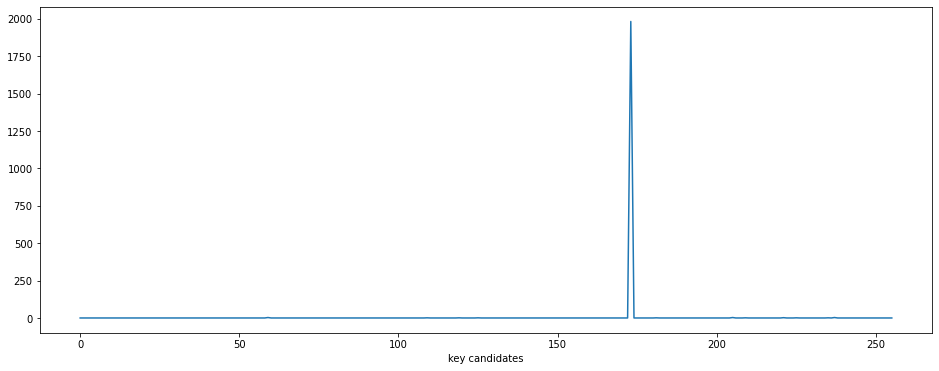

right key2:  101


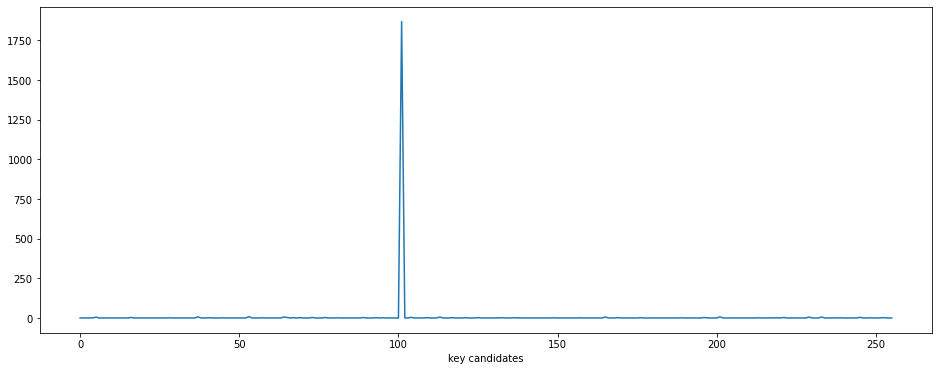

right key3:  48


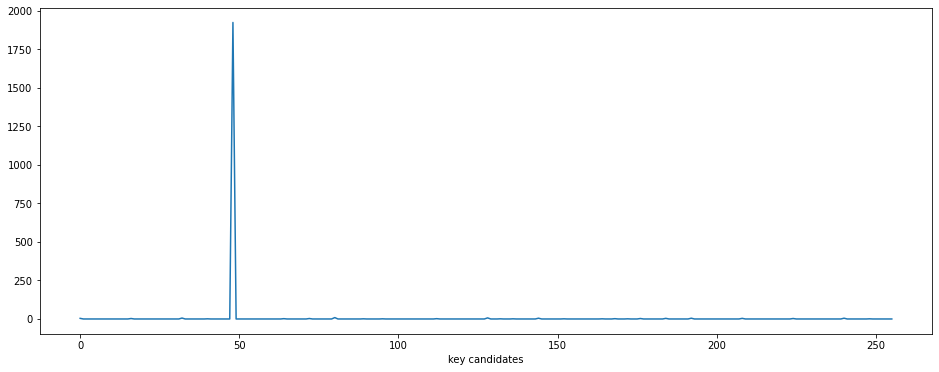

right key4:  235


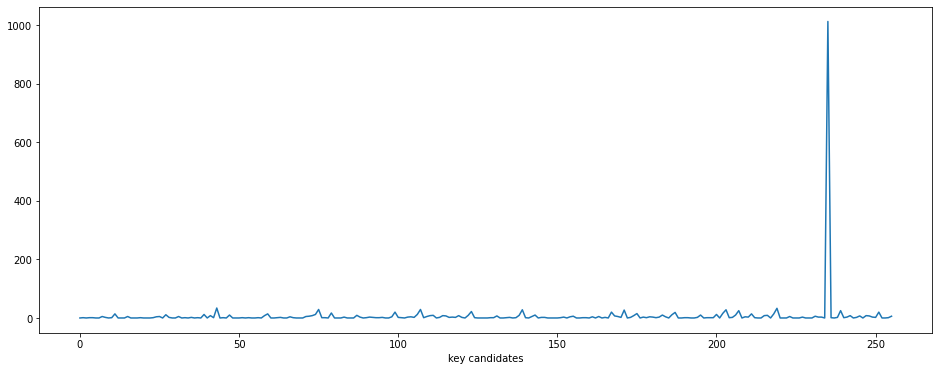

[173, 101, 48, 235]


In [18]:
pred_key_xor = predict_MLP_s(SCA_MLP1,SCA_MLP2,SCA_MLP3,SCA_MLP4, attack_traces_normal, plain) 
print(pred_key_xor)

In [19]:

g1_input = np.array(pred_key_xor^plain)
g1_ouput = [[0,0,0,0]]*2000

for i in range(0,2000):
  g1_ouput[i] = G(g1_input[i])



In [ ]:
#g2 함수에 대한 공격을 위해 새로운 모델을 학습합니다.

In [20]:
file_path = "/content/drive/MyDrive/2112/"


# convert .btr to .npy
#np.load("/content/drive/MyDrive/2112/profile_g2.npy")
profile_trace_g2  = np.load("/content/drive/MyDrive/2112/profile_g2.npy")#convert_btr_2_npy((27500,33500), file_path + 'ML-AVR-SEED.btr', '/content/drive/MyDrive/2112/profile_g2.npy')
profile_plain  = convert_hex_data_2_npy(file_path + 'ML-AVR-SEED-plain.txt',None)
profile_key    = convert_hex_data_2_npy(file_path + 'ML-AVR-SEED-key.txt', None)

In [31]:

profile_traces_normal_g2 = np.array(profile_trace_g2[:])


# 정규화 수행
for i in range(profile_traces_normal_g2.shape[0]):
    profile_traces_normal_g2[i] -= profile_traces_normal_g2[i].mean()
    MIN = min(profile_traces_normal_g2[i])
    MAX = max(profile_traces_normal_g2[i])
    profile_traces_normal_g2[i] = ((profile_traces_normal_g2[i] - MIN)/(MAX - MIN) - 0.5) * 2 #정규화를 진행


plain_list =  np.array([[int(profile_plain[k][i:i+2], 16)for i in range(0,len(profile_plain[0]),2)]for k in range(0, 5000)])
keys_list =  np.array([[int(profile_key[k][i:i+2], 16) for i in range(0,len(profile_key[0]),2)] for k in range(0, 5000)])
print(plain_list[0])
plain_list_L = np.array([ [(plain_list[j][i]) for i in range(0,8)]for j in range(0,5000)]) #이거 쉽게 plain_list_L = plain_list[:, :8] 하면될껄
plain_list_R = np.array([[(plain_list[j][8+i]) for i in range(0,8)]for j in range(0,5000)]) #plain_list_L = plain_list[:, 8:]
    
print(plain_list_R[0])
plain_list_C = np.array([[(plain_list_R[j][i]) for i in range(0,4)]for j in range(0,5000)]) #애두
plain_list_D = np.array([[(plain_list_R[j][4+i]) for i in range(0,4)]for j in range(0,5000)])
print('c = ', plain_list_C)

Sbox_input = np.array([[]])
KeyL_list= np.array([])
KeyR_list= np.array([])




#Sbox_input = np.zeros(5000,4)
for i in range(0,5000):
  KeyL, KeyR = round_1_key(keys_list[i])
  #print(KeyL)
  KeyL_list = np.append(KeyL_list,  KeyL, axis=0)
  KeyR_list = np.append(KeyR_list,  KeyR, axis=0)
KeyL_list = np.reshape(KeyL_list,(5000,4))
KeyR_list = np.reshape(KeyR_list,(5000,4))
KeyL_list = KeyL_list.astype('uint32')
KeyR_list = KeyR_list.astype('uint32')

Sbox_input = plain_list_C^KeyL_list^plain_list_D^KeyR_list

'''
for i in range(0,5000):
  for j in range(0,4):
    if j%2 == 0:
      Sbox_input[i][j] =  SBox2[Sbox_input[i][j]]
    else:
      Sbox_input[i][j] =  SBox1[Sbox_input[i][j]]

mid_value = Sbox_input
mid_value
'''
print('s_box =', Sbox_input[0])    

[  0  17  34  51  68  85 102 119 136 153 170 187 204 221 238 255]
[136 153 170 187 204 221 238 255]
c =  [[136 153 170 187]
 [ 96 122  43  78]
 [ 73 219 161  39]
 ...
 [217 142 252 248]
 [227  67 213 123]
 [  2 179 106 176]]
s_box = [ 29  70 115  53]


In [32]:
#이제 g2의 인풋을 계산해야하는데요, g2의 인풋은 C^KL 값과 g1의 output을 법덧셈(mod2^32)을 통해 구할 수 있습니다.

#먼저C^KL 값을 계산합니다.
pro_ck = plain_list_C^KeyL_list

#다음은 g1의 output을 명시해 줍니다. 앞에서 계산한 결과가 있겠죠? 그걸 쓰겠습니다.
pro_g1out = [[0,0,0,0]]*5000
for i in range(0,5000):
  pro_g1out[i] = G(Sbox_input[i]) #이게 될까 (5000,4)를 넣을 방법은..>?

print(pro_g1out[0])
pro_g2in = [[0,0,0,0]]*5000
mod = 0x1 << 32
for i in range(0,5000):
#두 list형의 배열들을 인트형으로 변환하여 법 덧셈을 진행합니다
  k = (list2hex(pro_ck[i])+list2hex(pro_g1out[i]))%mod

#여기에 정수를 다시 리스트로 바꿔서 저장해주는 동작과정을 추가해줍니다.
  pro_g2in[i] = [(k>>(8*(3-i)))&0xFF for i in range(0,4)]

print(pro_g2in[0])

[138, 249, 235, 239]
[102, 202, 204, 152]


In [33]:
#이렇게 얻은 g2의 인풋으로 g2의 아웃풋을 계산합니다.


Sbox_input = pro_g2in
for i in range(0,5000):
  for j in range(0,4):
    if j%2 == 0:
      Sbox_input[i][j] =  SBox2[Sbox_input[i][j]]
    else:
      Sbox_input[i][j] =  SBox1[Sbox_input[i][j]]

mid_value = np.array(Sbox_input)
print(mid_value)
#pro_g2sout = np.array(pro_g2sout)

[[106 188  33 244]
 [212 229 142 174]
 [108 183 231 181]
 ...
 [203 234 120  51]
 [  6 157 234 251]
 [175 223  48 219]]


In [34]:
#이제 x_train, y_train, x_layer, y_layer를 잡아 줍니다.
# 학습에 쓰일 파형의 개수 설정
num_traces = profile_trace_g2.shape[0]
num_training = int(num_traces * 0.9)

# SBox 결과
#mid_value

# 데이터 셔플링
rand_index = np.arange(0, num_traces)
np.random.shuffle(rand_index)

# 학습에서 사용할 입력(x_train)과 레이블(y_train)을 설정
x_train = profile_traces_normal_g2[rand_index[:num_training]]
y_train = mid_value[rand_index[:num_training]]


# 검증에서 사용할 입력(x_valid)과 레이블(y_valid)을 설정
x_valid = profile_traces_normal_g2[rand_index[num_training:]]
y_valid = mid_value[rand_index[num_training:]]

# 학습 데이터와 검증 데이터의 shape을 출력
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)

#동시에 y에 대하여 원핫인코딩을 수행해줍니다. 한바이트씩 진행할 것이므로 4개의 onehot이 나와야죠?
target_byte = 0

# 원핫 인코딩 수행
category = keras.layers.CategoryEncoding(256, output_mode = 'one_hot')
y_train_onehot1 = category(y_train[:,target_byte])
y_valid_onehot1 = category(y_valid[:,target_byte])

print(y_train_onehot1.shape)
print(y_valid_onehot1.shape)

#========================================
target_byte = 1

# 원핫 인코딩 수행
category = keras.layers.CategoryEncoding(256, output_mode = 'one_hot')
y_train_onehot2 = category(y_train[:,target_byte])
y_valid_onehot2 = category(y_valid[:,target_byte])

print(y_train_onehot2.shape)
print(y_valid_onehot2.shape)
#===========================================
target_byte = 2

# 원핫 인코딩 수행
category = keras.layers.CategoryEncoding(256, output_mode = 'one_hot')
y_train_onehot3 = category(y_train[:,target_byte])
y_valid_onehot3 = category(y_valid[:,target_byte])

print(y_train_onehot3.shape)
print(y_valid_onehot3.shape)
#======================================================
target_byte = 3

# 원핫 인코딩 수행
category = keras.layers.CategoryEncoding(256, output_mode = 'one_hot')
y_train_onehot4 = category(y_train[:,target_byte])
y_valid_onehot4 = category(y_valid[:,target_byte])

print(y_train_onehot4.shape)
print(y_valid_onehot4.shape)

(4500, 6001)
(4500, 4)
(500, 6001)
(500, 4)
(4500, 256)
(500, 256)
(4500, 256)
(500, 256)
(4500, 256)
(500, 256)
(4500, 256)
(500, 256)


In [35]:
#이제 정말 다됐어요,, mlp함수 짜고, 학습시켜요
def build_MLP(Points_len = 6001, Hidden_node = [400, 200], Output_node = 256, Activations = "relu", Dropout = True, BatchNo = False):

    # 입력층
    inp = keras.layers.Input(shape = (Points_len, ), name = "input") 

    # 입력층 배치 정규화
    Hidden_layer = keras.layers.BatchNormalization()(inp)

    for node in Hidden_node:
        # 은닉층 추가
        Hidden_layer = keras.layers.Dense(node, activation = Activations)(Hidden_layer)
        if Dropout: # 드롭아웃 수행
            Hidden_layer = keras.layers.Dropout(0.5)(Hidden_layer)
        if BatchNo: # 배치 정규화 수행
            Hidden_layer = keras.layers.BatchNormalization()(Hidden_layer)
    
    # 활성화 함수를 softmax로 설정 (각 class일 확률을 반환)
    out = keras.layers.Dense(Output_node, activation = 'softmax', name = 'output')(Hidden_layer)

    # 입력층과 출력층을 받아서 객체화
    m = keras.Model(inp, out)

    # 손실함수를 categorical_crossentropy, 성능 지표를 정확도로 설정하여 모델을 구성
    m.compile(optimizer = keras.optimizers.adam_v2.Adam(), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    # 모델 shape과 파라미터 수를 출력
    m.summary(80)

    return m

SCA2_MLP1 = build_MLP(6001, [1024, 512], 256, "relu", True, True)
SCA2_MLP2 = build_MLP(6001, [1024, 512], 256, "relu", True, True)
SCA2_MLP3 = build_MLP(6001, [1024, 512], 256, "relu", True, True)
SCA2_MLP4 = build_MLP(6001, [1024, 512], 256, "relu", True, True)


Model: "model_8"
________________________________________________________________________________
 Layer (type)                       Output Shape                    Param #     
 input (InputLayer)                 [(None, 6001)]                  0           
                                                                                
 batch_normalization_24 (BatchNorma  (None, 6001)                   24004       
 lization)                                                                      
                                                                                
 dense_16 (Dense)                   (None, 1024)                    6146048     
                                                                                
 dropout_16 (Dropout)               (None, 1024)                    0           
                                                                                
 batch_normalization_25 (BatchNorma  (None, 1024)                   4096        
 lization) 

Training started:  2021-11-21 07:34:03.472990
Epoch 1/50
90/90 [==============================] - ETA: 0s - loss: 6.0910 - accuracy: 0.0044
Epoch 00001: val_accuracy improved from -inf to 0.00800, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 5s 43ms/step - loss: 6.0910 - accuracy: 0.0044 - val_loss: 5.5780 - val_accuracy: 0.0080
Epoch 2/50
88/90 [============================>.] - ETA: 0s - loss: 5.8471 - accuracy: 0.0091
Epoch 00002: val_accuracy did not improve from 0.00800
90/90 [==============================] - 1s 13ms/step - loss: 5.8491 - accuracy: 0.0089 - val_loss: 5.5870 - val_accuracy: 0.0040
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 5.5817 - accuracy: 0.0158
Epoch 00003: val_accuracy improved from 0.00800 to 0.02000, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 4s 42ms/step - loss: 5.5817 - accuracy: 0.0158 - va

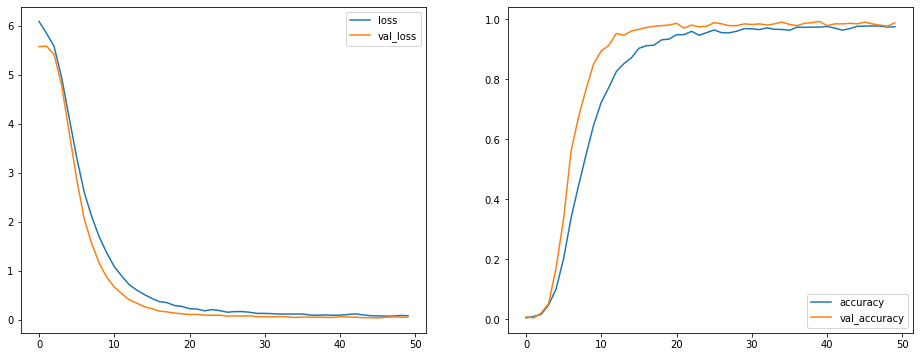

Training started:  2021-11-21 07:35:58.076046
Epoch 1/50
89/90 [============================>.] - ETA: 0s - loss: 6.0902 - accuracy: 0.0049
Epoch 00001: val_accuracy improved from -inf to 0.00400, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 5s 44ms/step - loss: 6.0892 - accuracy: 0.0049 - val_loss: 5.5927 - val_accuracy: 0.0040
Epoch 2/50
87/90 [============================>.] - ETA: 0s - loss: 5.8674 - accuracy: 0.0064
Epoch 00002: val_accuracy improved from 0.00400 to 0.01200, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 4s 46ms/step - loss: 5.8669 - accuracy: 0.0064 - val_loss: 5.6258 - val_accuracy: 0.0120
Epoch 3/50
88/90 [============================>.] - ETA: 0s - loss: 5.6881 - accuracy: 0.0080
Epoch 00003: val_accuracy did not improve from 0.01200
90/90 [==============================] - 1s 13ms/step - loss: 5.6861 - accuracy: 0.0080 - va

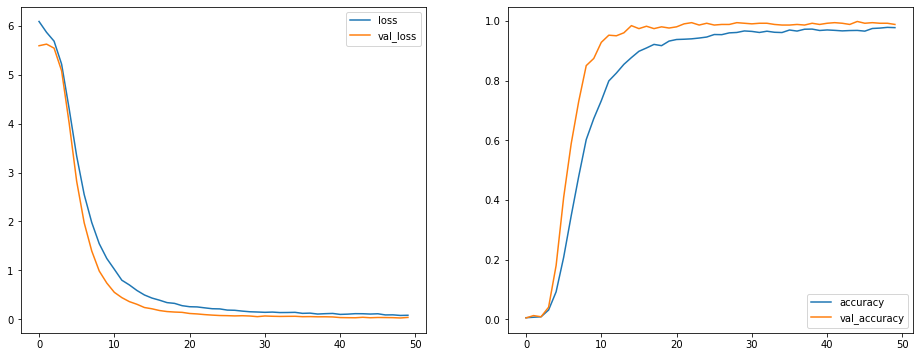

Training started:  2021-11-21 07:38:21.790526
Epoch 1/50
86/90 [===========================>..] - ETA: 0s - loss: 6.1228 - accuracy: 0.0035
Epoch 00001: val_accuracy improved from -inf to 0.00400, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 5s 44ms/step - loss: 6.1234 - accuracy: 0.0033 - val_loss: 5.5702 - val_accuracy: 0.0040
Epoch 2/50
89/90 [============================>.] - ETA: 0s - loss: 5.9229 - accuracy: 0.0058
Epoch 00002: val_accuracy improved from 0.00400 to 0.00600, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 4s 42ms/step - loss: 5.9217 - accuracy: 0.0058 - val_loss: 5.5740 - val_accuracy: 0.0060
Epoch 3/50
90/90 [==============================] - ETA: 0s - loss: 5.7876 - accuracy: 0.0084
Epoch 00003: val_accuracy improved from 0.00600 to 0.01000, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [======

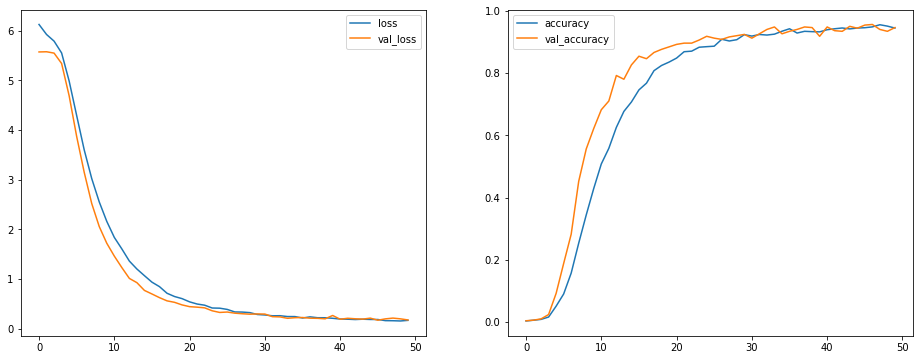

Training started:  2021-11-21 07:40:43.532922
Epoch 1/50
87/90 [============================>.] - ETA: 0s - loss: 6.1292 - accuracy: 0.0021
Epoch 00001: val_accuracy improved from -inf to 0.00400, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 5s 43ms/step - loss: 6.1264 - accuracy: 0.0020 - val_loss: 5.5664 - val_accuracy: 0.0040
Epoch 2/50
86/90 [===========================>..] - ETA: 0s - loss: 5.8902 - accuracy: 0.0051
Epoch 00002: val_accuracy improved from 0.00400 to 0.00600, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [==============================] - 4s 42ms/step - loss: 5.8889 - accuracy: 0.0051 - val_loss: 5.5882 - val_accuracy: 0.0060
Epoch 3/50
89/90 [============================>.] - ETA: 0s - loss: 5.7807 - accuracy: 0.0094
Epoch 00003: val_accuracy improved from 0.00600 to 0.01200, saving model to ./MLSCA
INFO:tensorflow:Assets written to: ./MLSCA/assets
90/90 [======

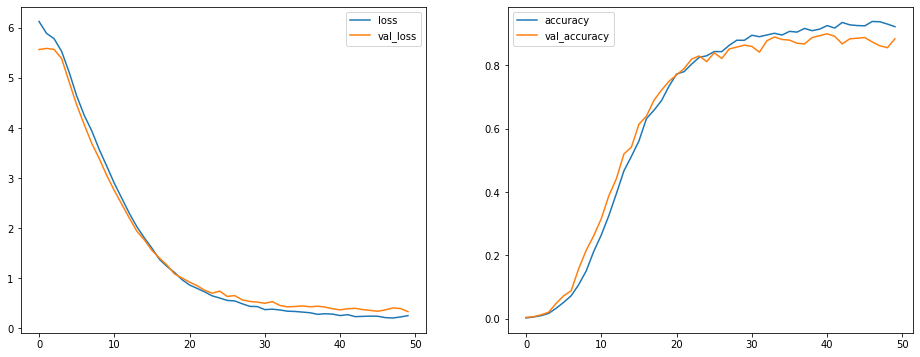

In [36]:
def train(model, Init, epochs, x_train, y_train, x_valid, y_valid, batch_size, verbose, file_name):

    # epoch 20 동안 validation accuracy의 향상이 없으면 학습 중지
    earlystop = keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 20, verbose = 1)

    # validation accuracy가 향상된 결과의 모델 파라미터만 저장
    checkpoint = keras.callbacks.ModelCheckpoint(filepath = './MLSCA', monitor = 'val_accuracy', verbose = verbose, save_best_only = True, mode = 'max')
  
    # 학습 시작 시간 측정
    print("Training started: ", datetime.datetime.now())
    start = time.time()
    
    # 가중치 초기화 
    model.set_weights(Init)

    # 신경망 학습 수행
    model.fit(x = x_train, y = y_train, validation_data = (x_valid, y_valid), initial_epoch = 0, epochs = epochs, batch_size = batch_size, callbacks=[checkpoint], verbose = verbose)

    # 학습 종료 시간 측정 및 소요 시간 계산
    elapsed = time.time() - start
    print("Training ended: ", datetime.datetime.now())
    print("Elapsed", elapsed)
    
    val_loss_load = model.history.history['val_loss']
    val_acc_load = model.history.history['val_accuracy']
    loss_load = model.history.history['loss']
    acc_load = model.history.history['accuracy']

    # 학습 결과 그래프 출력
    fig = plt.figure(figsize = (16, 6))
    ax = plt.subplot(1, 2, 1)
    ax.plot(loss_load)
    ax.plot(val_loss_load)
    ax.legend(['loss','val_loss'])
    ax = plt.subplot(1, 2, 2)
    ax.plot(acc_load)
    ax.plot(val_acc_load)
    ax.legend(['accuracy','val_accuracy'])
    plt.savefig(file_name + 'val_loss_and_acc.png')
    plt.show()
    
    # 학습 결과, 손실값과 정확도를 파일로 저장
    np.savetxt(file_name+"val_loss.txt", val_loss_load)
    np.savetxt(file_name+"val_acc.txt", val_acc_load)

#=============================================================================================================================
init_weights1 = SCA2_MLP1.get_weights()

train(SCA2_MLP1,init_weights1 , 50 ,x_train , y_train_onehot1, x_valid, y_valid_onehot1,50, 1,'seed_attack_model1')
#=============================================================================================================================
init_weights2 = SCA2_MLP2.get_weights()
train(SCA2_MLP2,init_weights2 , 50 ,x_train , y_train_onehot2, x_valid, y_valid_onehot2,50, 1,'seed_attack_model2')
#=============================================================================================================================
init_weights3 = SCA2_MLP3.get_weights()

train(SCA2_MLP3,init_weights3 , 50 ,x_train , y_train_onehot3, x_valid, y_valid_onehot3,50, 1,'seed_attack_model3')
#=============================================================================================================================
init_weights4 = SCA2_MLP4.get_weights()

train(SCA2_MLP4,init_weights4 , 50 ,x_train , y_train_onehot4, x_valid, y_valid_onehot4,50, 1,'seed_attack_model4')


In [37]:
#공격 파형을 불러옵니다.
file_path = "/content/drive/MyDrive/2111/"
attack_trace2  = convert_btr_2_npy((40000,46000), file_path + 'AVR-SEED.btr', 'attack_trace2.npy')

attack_traces_normal2 = np.array(attack_trace2[:])

# 정규화 수행
for i in range(attack_trace2.shape[0]):
    attack_traces_normal2[i] -= attack_traces_normal2[i].mean()
    MIN = min(attack_traces_normal2[i])
    MAX = max(attack_traces_normal2[i])
    attack_traces_normal2[i] = ((attack_traces_normal2[i] - MIN)/(MAX - MIN) - 0.5) * 2 #정규화를 진행


Binary Traces file. (.btr)
--------------------------------------------------
* Trace-2000
--------------------------------------------------
Traces - attack_trace2.npy saved.


keyL1:  227


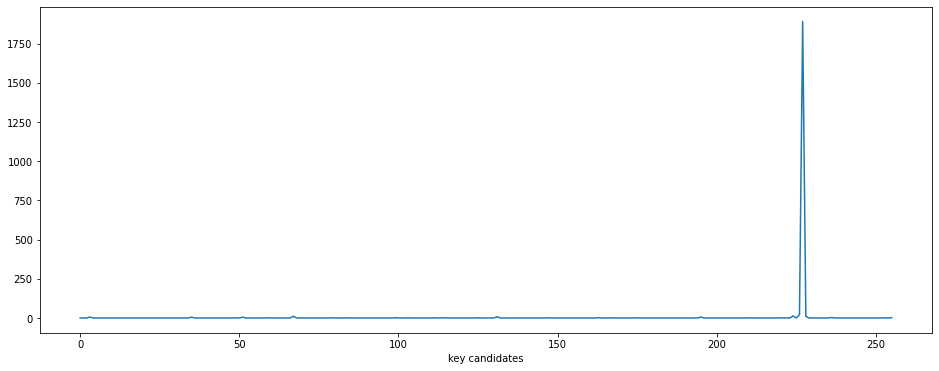

keyL2:  82


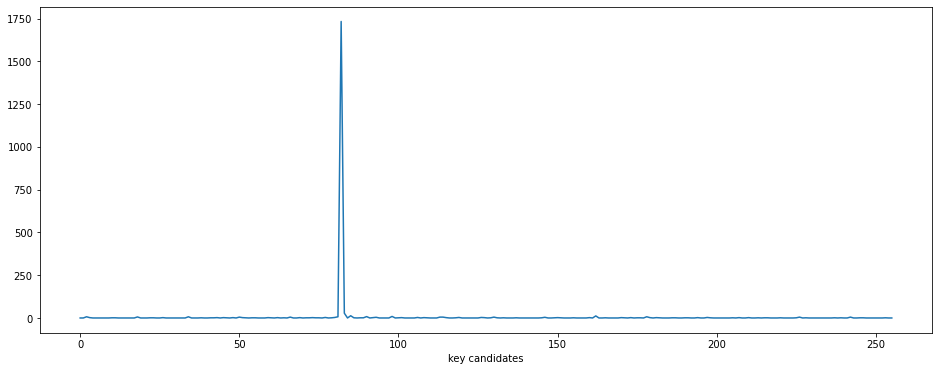

keyL3:  243


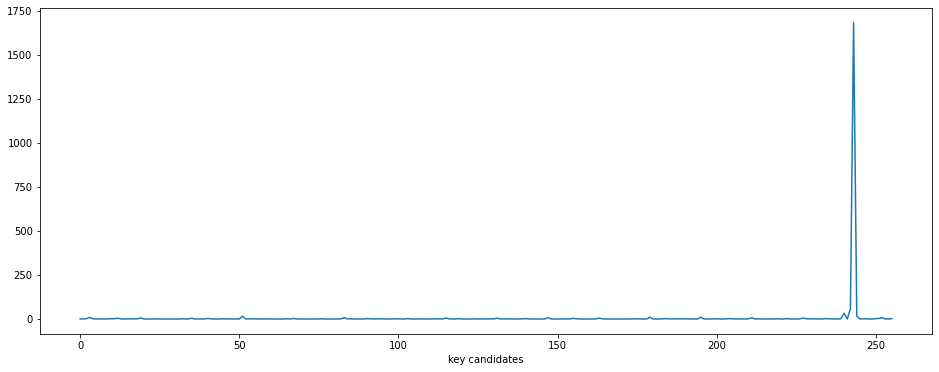

KeyL4:  32


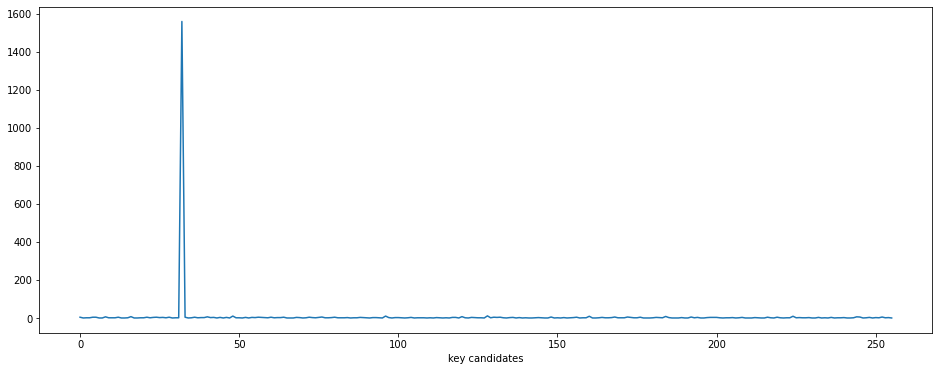

[227, 82, 243, 32]


In [38]:
#앞에서 구한 Attack_g1_output과 학습모델을 통해 예측한 g2의 인풋을 법뺄셈을 해줍니다. 그렇게 얻은 값은 KL^C입니다.
#KL을 구하기 위해 C를 xor해주고 KL의 카운트중 가장 많이 나온 친구를 KL이라고 예측하는거에요

def predict_MLP_s2(model1,model2,model3,model4, trace_test, g1out, attack_plain_list_C):

    # 신경망의 출력 값(sbox 출력 값) 획득
    predict_sbox1 = model1.predict(trace_test)

    # one-hot encoding 결과 값 중 최대 값의 인덱스 추출
   
    sbox_out_val1 = np.argmax(predict_sbox1,axis=1)
    
    sbox_in_val1 = np.array(inv_SBox2)[sbox_out_val1.astype(int)]

    
   

#=================================================================================================
    predict_sbox2 = model2.predict(trace_test)

    # one-hot encoding 결과 값 중 최대 값의 인덱스 추출
   
    sbox_out_val2 = np.argmax(predict_sbox2,axis=1)
    
    sbox_in_val2 = np.array(inv_SBox1)[sbox_out_val2.astype(int)]

    
   

#==========================================================================================
    predict_sbox3 = model3.predict(trace_test)

    # one-hot encoding 결과 값 중 최대 값의 인덱스 추출
   
    sbox_out_val3 = np.argmax(predict_sbox3,axis=1)
    
    sbox_in_val3 = np.array(inv_SBox2)[sbox_out_val3.astype(int)]

   
   

#==================================================================================================
    predict_sbox4 = model4.predict(trace_test)

    # one-hot encoding 결과 값 중 최대 값의 인덱스 추출
   
    sbox_out_val4 = np.argmax(predict_sbox4,axis=1)
    
    sbox_in_val4 = np.array(inv_SBox1)[sbox_out_val4.astype(int)]
    
   
#===================================================================================================
    sbox_in_val_all = [[0,0,0,0]]*2000
    for i in range(0,2000):
      sbox_in_val_all[i] = [sbox_in_val1[i],sbox_in_val2[i],sbox_in_val3[i],sbox_in_val4[i]]



    mod = 0x1 << 32
    KeyL_list= np.array([])
    
    for i in range(0,2000):
      guess_key = (list2hex(sbox_in_val_all[i]) - list2hex(g1out[i]))%mod
      KL_sp = np.array([(guess_key>>(8*(3-j)))&0xFF for j in range(0,4)])
      KeyL_list = np.append(KeyL_list,  KL_sp, axis=0)

    KeyL_list = np.reshape(KeyL_list,(2000,4))
    KeyL_list = KeyL_list.astype('uint32')
    KeyL_list = KeyL_list^attack_plain_list_C

    guess_key1 = KeyL_list[:,0]
    guess_key2 = KeyL_list[:,1]
    guess_key3 = KeyL_list[:,2]
    guess_key4 = KeyL_list[:,3]


    # 1바이트의 키 후보 별 계산된 추측 키 카운팅
    unique, counts = np.unique(guess_key1, return_counts = True)
    key_count = np.zeros(256)
    key_count[unique] = counts

    # 가장 많이 카운팅 된 추측 키 계산
    pred_key1 = np.argmax(key_count)
    
    print('keyL1: ', (pred_key1))

    plt.figure(figsize = (16, 6))
    plt.plot(key_count)
    plt.xlabel('key candidates')
    plt.show()

     # 1바이트의 키 후보 별 계산된 추측 키 카운팅
    unique, counts = np.unique(guess_key2, return_counts = True)
    key_count = np.zeros(256)
    key_count[unique] = counts

    # 가장 많이 카운팅 된 추측 키 계산
    pred_key2 = np.argmax(key_count)
    
    print('keyL2: ', (pred_key2))

    plt.figure(figsize = (16, 6))
    plt.plot(key_count)
    plt.xlabel('key candidates')
    plt.show()

    # 1바이트의 키 후보 별 계산된 추측 키 카운팅
    unique, counts = np.unique(guess_key3, return_counts = True)
    key_count = np.zeros(256)
    key_count[unique] = counts

    # 가장 많이 카운팅 된 추측 키 계산
    pred_key3 = np.argmax(key_count)
    
    print('keyL3: ', (pred_key3))

    plt.figure(figsize = (16, 6))
    plt.plot(key_count)
    plt.xlabel('key candidates')
    plt.show()

     # 1바이트의 키 후보 별 계산된 추측 키 카운팅
    unique, counts = np.unique(guess_key4, return_counts = True)
    key_count = np.zeros(256)
    key_count[unique] = counts

    # 가장 많이 카운팅 된 추측 키 계산
    pred_key4 = np.argmax(key_count)
    
    print('KeyL4: ', (pred_key4))

    plt.figure(figsize = (16, 6))
    plt.plot(key_count)
    plt.xlabel('key candidates')
    plt.show()
    return [pred_key1,pred_key2,pred_key3,pred_key4]

pred_key_KL = predict_MLP_s2(SCA2_MLP1, SCA2_MLP2,SCA2_MLP3,SCA2_MLP4, attack_traces_normal2,g1_ouput,attack_plain_list_C) 
print(pred_key_KL)


In [39]:
#KL을 알면 앞서 구한 KR^KL을 통해 KR을 구할 수 있겠죠...?
pred_key_KL = np.array(pred_key_KL)
pred_key_KR = pred_key_xor^pred_key_KL
pred_key_KR

array([ 78,  55, 195, 203])

In [40]:
#실제 키 파일을 불러와서 잘 수행됨을 보여줍니다.
print(KL,KR)

[227  82 243  32] [ 78  55 195 203]
